### LOGISTIC REGRESSION
In this assignment we try to find a relation between average weight of granules and total surface area to see if a material is viable as a catalyst

In [1]:
# Importing libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Feature mapping
Sometimes, we are given an inadequate number of features for which training the dataset becomes difficult.  
Hence we create new features of by taking polynomial products of existing ones.

In [60]:
def feature_map(points):
    points = np.array(points)
    x, y = points[:, 0], points[:, 1]
    
    features = [np.ones_like(x)]
    for a in range(1,5):
        for b in range(a+1):
            features.append((x**(a))*(y**(b-a)))    
    return np.column_stack(features)

### Creating the class for Logistic Regression

In [41]:
class LogisticRegression:
    def __init__(self) -> None:
        self.weights : np.ndarray | None = None
        self.bias : float | None = None
    def __sigmoid(self, z: np.ndarray) -> np.ndarray:
        sig = 1/(1+np.exp(-z))
        return sig
    def predict_probability(self, X: np.ndarray) -> np.ndarray:
        z=np.dot(X,self.weights)+self.bias
        return self.__sigmoid(z)
    def predict(self, X: np.ndarray) -> np.ndarray:
        prob = self.predict_probability(X)
        return (prob>=0.5).astype(int)
    def __loss(self, X: np.ndarray, y: np.ndarray, lambda_reg: float = 0) -> tuple:
        m = len(y)
        h = self.predict_probability(X) 
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h)) 
        loss += (lambda_reg / (2 * m)) * np.sum(self.weights ** 2) 
        dw = (1 / m) * np.dot(X.T, (h - y)) 
        dw += (lambda_reg / m) * self.weights  
        db = (1 / m) * np.sum(h - y)
        return loss, dw, db
    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 500,
            learning_rate: float = 0.01, threshold: float = 0.0001, 
            lambda_reg: float = 10) -> None:
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        for _ in range(epochs):
            loss, dw, db = self.__loss(X, y, lambda_reg)
            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db
            if np.linalg.norm(dw) < threshold and abs(db) < threshold:
             break


In [5]:
# Importing data
df = pd.read_csv('logistic_data.csv')
data = df.to_numpy()
X = data[:, :2]
y = data[:, 2]

In [6]:
# Creating train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
def z_score(X: np.ndarray) -> tuple:
    x_mean = np.mean(X, axis=0)
    x_std = np.std(X, axis=0)
    x = (X - x_mean) / x_std
    return x, x_mean, x_std

In [10]:
# Normalizing the data (we use the same constants to maintain consistency)
X_train, x_mean, x_std = z_score(X_train)
X_test = (X_test - x_mean) / x_std
x_train = feature_map(X_train)
x_test = feature_map(X_test)

In [11]:
# Visualizing how the boundary curve looks like
def plot_decision_boundary(X_original, y, model, resolution=500):
    # Set up the grid for the decision boundary
    x_min, x_max = X_original[:, 0].min() - 1, X_original[:, 0].max() + 1
    y_min, y_max = X_original[:, 1].min() - 1, X_original[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    
    # Flatten the grid points and map to expanded features
    grid_original = np.c_[xx.ravel(), yy.ravel()]
    grid_expanded = feature_map(grid_original)
    
    # Predict the grid values for decision boundary
    Z = model.predict(grid_expanded)
    Z = Z.reshape(xx.shape)
    
    # Plot the data points
    true_points = X_original[y == 1]
    false_points = X_original[y == 0]
    plt.scatter(true_points[:, 0], true_points[:, 1], label="True", c="blue", marker="o", s=20)
    plt.scatter(false_points[:, 0], false_points[:, 1], label="False", c="red", marker="x", s=20)

    # Plot the decision boundary
    plt.contour(xx, yy, Z, levels=[0.5], colors="black", linewidths=2)
    
    # Labeling and title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary and Data Points")
    plt.show()

We plot the decision boundary that the model predicts. This can be used to check for overfitting.  
If the boundary starts looking like an ameoba trying to fit every point, then it is a sign of overfitting.

Your model has an accuracy of 70.0%


/tmp/ipykernel_39129/2233233167.py:6: RuntimeWarning: overflow encountered in exp
  sig = 1/(1+np.exp(-z))


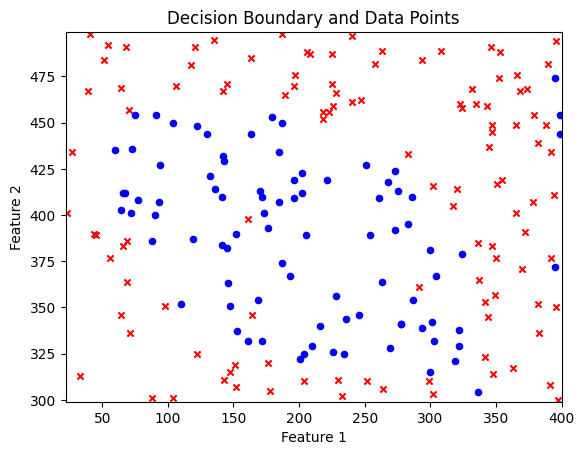

In [61]:
# Checking accuracy of test model
model = LogisticRegression()
model.fit(x_train, y_train, epochs=5000, learning_rate=0.01, threshold=0.0001, lambda_reg=10)
y_pred = model.predict(x_test)

accuracy = np.mean(y_pred == y_test) * 100
print(f"Your model has an accuracy of {accuracy}%")

# Plotting the contour and checking for overfitting (try changing the degree in the feature_map function to 10 instead)
plot_decision_boundary(((X - x_mean) / x_std), y, model)